In [1]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import pandas as pd
from sksurv.svm import FastKernelSurvivalSVM
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sksurv.metrics import concordance_index_censored, integrated_brier_score, brier_score
from lifelines.utils.sklearn_adapter import sklearn_adapter
from lifelines.utils import concordance_index
from scipy.stats import gumbel_r, norm, logistic
import lifelines.datasets as dset
import math
from sklearn.calibration import calibration_curve, CalibrationDisplay
from matplotlib.gridspec import GridSpec
import warnings
from scipy.special import erf
from sklearn.preprocessing import StandardScaler
import sys
# sys.path.append('/home/liuxin/HACSurv')
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import torch
import torchtuples as tt

from pycox.preprocessing.label_transforms import LabTransDiscreteTime
from pycox.models import DeepHit
from pycox.evaluation import EvalSurv

In [ ]:
#Showing our trained HAC
from survival import MixExpPhiStochastic,InnerGenerator,InnerGenerator2,sample,Copula
def sampleInner(phi, ndims, n, M0=None):
    device = phi.mu.device  # 获取phi.mu的设备，确保所有操作都在同一设备上进行
    
    if M0 is None:
        M0 = phi.psi.sample_M(n).to(device)  # 确保M0在正确的设备上
    
    njumps = torch.poisson(torch.exp(phi.beta) * M0).int()
    
    # 确保c也在同一个设备
    c = torch.tensor([phi.sample_M(njumps[i].item()).sum() for i in range(n)], device=device)
    
    lso = torch.exp(phi.mu) * M0 + c  # 现在phi.mu, M0和c都在同一个设备上
    
    M = lso[:, None].expand(-1, ndims)
    e = torch.distributions.exponential.Exponential(torch.ones((n, ndims), device=device))  # 确保指数分布也在同一设备上
    E = e.sample()
    
    return phi.forward(E / M)
device = torch.device("cpu")
psi = MixExpPhiStochastic(device)
psi_cop = Copula(psi,device)

ckpt_path_out = './Competing_SYN/checkpoint/Example_competing_syn_outer_02_step1.pth'
    
ckpt_out = torch.load(ckpt_path_out)

phi_out_keys = {k.replace('phi.', ''): v for k, v in ckpt_out['model_state_dict'].items() if 'phi' in k and 'phi_inv' not in k}

psi.load_state_dict(phi_out_keys)
psi.resample_M(1000)

#psi0 = ClaytonPhi(torch.tensor(1.0))

phi01 = InnerGenerator(psi,device)
phi01_cop = Copula(phi01,device)
ckpt = torch.load('./Competing_SYN/checkpoint/Example_competing_syn_inner01_step2.pth')
# /home/liuxin/HACSurv/checkpoints/competing_syn_inner23_step2.pth
phi01_cop.load_state_dict(ckpt['model_state_dict'])
#phi01.psi = psi0

phi23 = InnerGenerator(psi,device)
phi23_cop = Copula(phi23,device)
ckpt = torch.load('./Competing_SYN/checkpoint/Example_competing_syn_inner23_step2.pth')
phi23_cop.load_state_dict(ckpt['model_state_dict'])
#phi23.psi = psi0

phi01.resample_M(1000)
phi23.resample_M(1000)

M0 = psi.sample_M(3000).detach()
#M0 = psi0.sample_M(3000).detach()
U01 = sampleInner(phi01, 2, 3000, M0=M0).detach()
U23 = sampleInner(phi23, 2, 3000, M0=M0).detach()
U = torch.cat([U01,U23],dim=1)


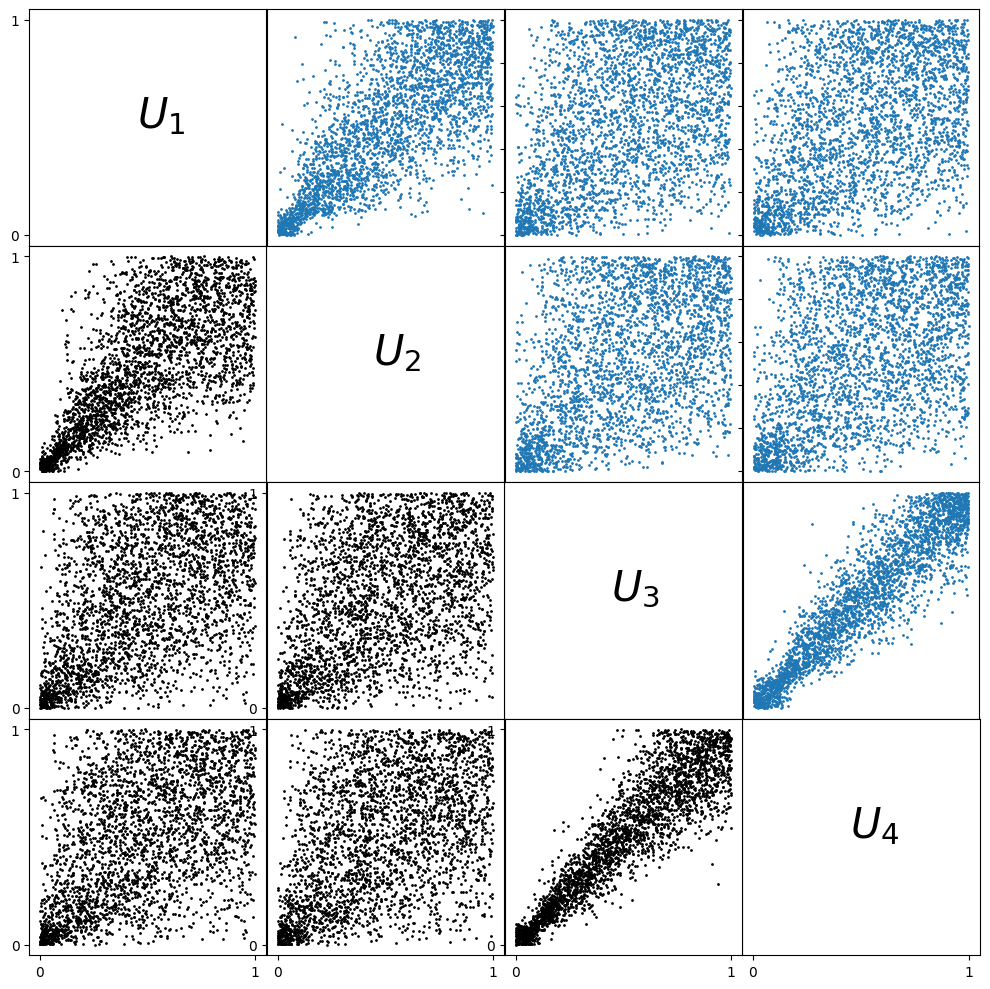

<Figure size 640x480 with 0 Axes>

In [7]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
# Get the default color
default_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
def setup_axes(ax, with_labels=False):
    ax.axis('square')
    if with_labels:
        ax.set_xticks([0, 1])
        ax.set_yticks([0, 1])
        ax.set_xticklabels(['0', '1'])
        ax.set_yticklabels(['0', '1'])
    else:
        ax.set_xticks([])
        ax.set_yticks([])
fig = plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(4, 4, wspace=0.0, hspace=0.0) 

ax = plt.subplot(gs[0,1])
ax.scatter(U[:,0], U[:,1], s=1, c=default_color)
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.axis('square'); ax.set_xticklabels([]); ax.set_yticklabels([])

ax = plt.subplot(gs[0,2])
ax.scatter(U[:,0], U[:,2], s=1, c=default_color)
ax.axis('square'); ax.set_xticklabels([]); ax.set_yticklabels([])

ax = plt.subplot(gs[0,3])
ax.scatter(U[:,0], U[:,3], s=1, c=default_color)
ax.axis('square'); ax.set_xticklabels([]); ax.set_yticklabels([])

ax = plt.subplot(gs[1,2])
ax.scatter(U[:,1], U[:,2], s=1, c=default_color)
ax.axis('square'); ax.set_xticklabels([]); ax.set_yticklabels([])

ax = plt.subplot(gs[1,3])
ax.scatter(U[:,1], U[:,3], s=1, c=default_color)
ax.axis('square'); ax.set_xticklabels([]); ax.set_yticklabels([])

ax = plt.subplot(gs[2,3])
ax.scatter(U[:,2], U[:,3], s=1, c=default_color)
ax.axis('square'); ax.set_xticklabels([]); ax.set_yticklabels([])

ax = plt.subplot(gs[0,0])
ax.text(0.45,0.5,'$U_1$',fontsize=30)
ax.axis([xmin, xmax, ymin, ymax])
ax.set_xticklabels([]); ax.set_yticklabels([])
ax.set_yticks([0,1]); ax.set_yticklabels([0,1])

ax = plt.subplot(gs[1,1])
ax.text(0.45,0.5,'$U_2$',fontsize=30)
ax.set_xticklabels([]); ax.set_yticklabels([])

ax = plt.subplot(gs[2,2])
ax.text(0.45,0.5,'$U_3$',fontsize=30)
ax.set_xticklabels([]); ax.set_yticklabels([])

ax = plt.subplot(gs[3,3])
ax.text(0.45,0.5,'$U_4$',fontsize=30)
ax.axis([xmin, xmax, ymin, ymax])
ax.set_xticklabels([]); ax.set_yticklabels([])
ax.set_xticks([0,1]); ax.set_xticklabels([0,1])

file_path = './U_data.csv'  # 替换成你的文件路径
data = pd.read_csv(file_path)
indices = np.random.choice(data.shape[0], size=3000, replace=False)
real_data = data.iloc[indices].values
for i in range(4):
    for j in range(i + 1, 4):
        ax = plt.subplot(gs[j, i])
        ax.scatter(real_data[:, i], real_data[:, j], s=1, c='black')
        ax.axis('square')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        setup_axes(ax, with_labels=1)
        

plt.tight_layout()
plt.show()
plt.clf()


In [ ]:
#step2
#learn inner copula
#In this example, you should learn two inner copula. 01 and 23

from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from survival import MixExpPhiStochastic,InnerGenerator
import torch.optim as optim
##训练inner
from survival import sample,Copula,HACSurv_2D

device = torch.device("cuda:1")

# 固定随机数种子
torch.set_default_tensor_type(torch.DoubleTensor)
phi = MixExpPhiStochastic(device)

model =HACSurv_2D_shared(phi, device = device, num_features=10, tol=1e-10, hidden_size = 32).to(device)
# model = HACSurv_2D(phi, device = device, num_features=10, tol=1e-10, hidden_size = 32).to(device)
print(device)
#要学习的inner的copula参数
checkpoint = torch.load('/home/liuxin/HACSurv/checkpoints/HAC_linearSyn_inner23_step1.pth')

model.load_state_dict(checkpoint['model_state_dict'])

model.phi.resample_M(200)
samples = sample(model, 2, 5000, device =  device)
# print(samples.shape)
num_train_samples = 4000
num_test_samples = 1000  # 或者通过 samples.shape[0] - num_train_samples 计算得到


plt.scatter(samples[:, 0].cpu(), samples[:, 1].cpu(), s=15)
# os.makedirs('/home/liuxin/GenACSurvival-main/sample_figs/'+copula_form+'/'+str(theta_true), exist_ok=True)
plt.savefig('/home/liuxin/HACSurv_Camera_Ready/Competing_SYN/figure/competing_syn_23.png' )


# 分割样本
train_data = samples[:num_train_samples]
test_data = samples[num_train_samples:num_train_samples + num_test_samples]
psi = MixExpPhiStochastic(device)
#选取censor和e2的copula作为外部copula
ckpt_path_out = '/home/liuxin/HACSurv/checkpoints/outer_linear_competing02.pth'
    
ckpt_out = torch.load(ckpt_path_out)
        # # # print(ckpt_out)
        
phi_out_keys = {k.replace('phi.', ''): v for k, v in ckpt_out['model_state_dict'].items() if 'phi' in k and 'phi_inv' not in k}
psi.load_state_dict(phi_out_keys)        
phi = InnerGenerator(psi,device)
net = Copula(phi,device)
optim_args = \
    {
        'lr': 1e-5, # it is 1e-3 since torch.sum was used instead of torch.mean for loglikelihood
        'momentum': 0.9
    }

optimizer = optim.SGD(net.parameters(), optim_args['lr'], optim_args['momentum'])
num_epochs = 10000
batch_size = 4000
chkpt_freq = 500
patience = 1000
best_val_loss = np.inf
epochs_no_improve = 0
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1000000, shuffle=True)
    
train_loss_per_epoch = []
# print('1')
for epoch in range(num_epochs):
        # print(epoch)
        loss_per_minibatch = []
        for i, data in enumerate(train_loader, 0):
            optimizer.zero_grad()

            if hasattr(net.phi.psi, 'resample_M'):
                net.phi.psi.resample_M(100)
            net.phi.resample_M(100)

            d = data.detach().clone().to(device)
            p = net(d, mode='pdf')
            # print('2')
            scaleloss = torch.square(torch.mean(net.phi.M)-1)
            logloss = -torch.sum(torch.log(p))
            reg_loss = logloss+scaleloss
            reg_loss.backward()
            # loss_per_minibatch.append((logloss / p.numel()).detach().cpu().numpy())
            # loss_per_minibatch.append((logloss/p.numel()).detach().numpy())
            optimizer.step()

        # train_loss_per_epoch.append(np.mean(loss_per_minibatch))

        # 验证集性能评估
        if epoch % 100 == 0:
            val_logloss = 0
            for i, data in enumerate(test_loader, 0):
                if hasattr(net.phi.psi, 'resample_M'):
                    net.phi.psi.resample_M(1000)
                net.phi.resample_M(1000)
                d = data.detach().clone().to(device)
                p = net(d, mode='pdf')
                val_logloss += -torch.mean(torch.log(p)).item()
            val_logloss /= len(test_loader)

            # 更新最佳模型
            if val_logloss < best_val_loss:
                best_val_loss = val_logloss
                epochs_no_improve = 0
                # 保存模型状态
                checkpoint_path = os.path.join('./Competing_SYN/figure', 'competing_syn_inner23_step2.pth')
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': net.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': val_logloss,
                }, checkpoint_path)

                # 生成并保存样本图像
                samples = sampleInner(net.phi, 2, 5000).detach().cpu()
                plt.scatter(samples[:, 0], samples[:, 1],s=15)
                # plt.axis("square")
                plot_path = os.path.join('./Competing_SYN/figure', 'competing_syn_inner23_step2.png')
                plt.savefig(plot_path)
                plt.clf()

                print('Epoch {}: Train {}, Val {}'.format(epoch, reg_loss.item(), val_logloss))
            else:
                epochs_no_improve += 100

            # 早停检查
            if epochs_no_improve >= patience:
                print('Early stopping triggered at epoch:', epoch)
                break

cuda:1
Sampling from dim: 1
Epoch 0: Train -1869.5988847496099, Val -0.4630401258656203
Epoch 100: Train -1811.9590534203865, Val -0.4692509337772456
Epoch 500: Train -1981.3328096658108, Val -0.4965575615838221
Epoch 600: Train -2292.1134326245556, Val -0.7072606024522717
Epoch 700: Train -3157.7211531472694, Val -0.8196297399775944
Epoch 800: Train -3652.0251384853823, Val -0.9431458265834299
Epoch 900: Train -3821.286758694964, Val -0.9596631494176723
Epoch 1000: Train -3917.015422450103, Val -0.9928181738943738
Epoch 1100: Train -4033.584039862539, Val -1.0045998546088521
Epoch 1200: Train -4041.717958894855, Val -1.0219342908882703
Epoch 1300: Train -4056.1744016912785, Val -1.0235740313952377
Epoch 1400: Train -4104.80015626626, Val -1.0262982099755011
Epoch 1500: Train -4119.000823047141, Val -1.0392245107846845
Epoch 2300: Train -4001.032453373586, Val -1.0443874101856816
Epoch 2400: Train -4112.9991771041205, Val -1.0450199127563875
Early stopping triggered at epoch: 3400


<Figure size 640x480 with 0 Axes>